In [12]:
import pandas as pd

df = pd.read_csv("augmented_bias_dataset.csv")
df.head()

,text,bias
0,I’m not selling at a loss.,loss_aversion
1,I’m not selling at a loss. That's my decision.,loss_aversion
2,"Honestly, i’m not selling at a loss.",loss_aversion
3,We’m not selling at a loss.,loss_aversion
4,I’m not selling at a loss. It's probably the r...,loss_aversion


In [13]:
import re
import string

def preprocess(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(preprocess)


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["clean_text"])
y = df["bias"]


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [17]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
                     precision    recall  f1-score   support

fear_of_missing_out       1.00      1.00      1.00         1
     overconfidence       1.00      1.00      1.00         1
       recency_bias       1.00      1.00      1.00         2
    regret_aversion       1.00      1.00      1.00         2
       social_proof       1.00      1.00      1.00         2
    status_quo_bias       1.00      1.00      1.00         2

           accuracy                           1.00        10
          macro avg       1.00      1.00      1.00        10
       weighted avg       1.00      1.00      1.00        10



In [19]:
def predict_bias(text):
    text_clean = preprocess(text)
    vector = vectorizer.transform([text_clean])
    prediction = model.predict(vector)
    return prediction[0]



In [20]:
print("Bias Detected:", predict_bias("Everyone seems to be buying this."))

Bias Detected: herd_mentality


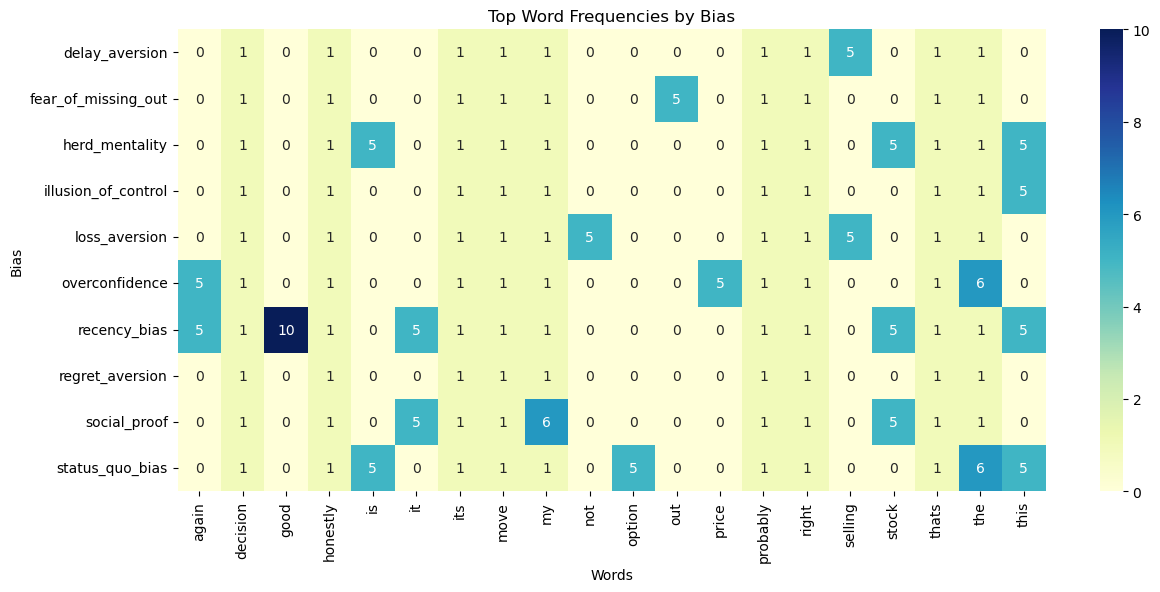

In [24]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=20)
X_counts = cv.fit_transform(df["clean_text"])
word_counts = pd.DataFrame(X_counts.toarray(), columns=cv.get_feature_names_out())
word_counts["bias"] = df["bias"]

heatmap_data = word_counts.groupby("bias").sum()

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.title("Top Word Frequencies by Bias")
plt.xlabel("Words")
plt.ylabel("Bias")
plt.show()


In [25]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
coef = model.coef_
classes = model.classes_

top_n = 5  # top 5 words per bias

for i, class_label in enumerate(classes):
    top_features = np.argsort(coef[i])[-top_n:]
    print(f"🔍 Top features for {class_label}:")
    for idx in reversed(top_features):
        print(f"   {feature_names[idx]} ({coef[i][idx]:.3f})")
    print()


🔍 Top features for delay_aversion:
   me (0.842)
   longer (0.842)
   wait (0.842)
   little (0.842)
   before (0.842)

🔍 Top features for fear_of_missing_out:
   don (0.874)
   to (0.874)
   miss (0.874)
   want (0.874)
   out (0.874)

🔍 Top features for herd_mentality:
   buying (1.202)
   everyone (1.202)
   is (0.837)
   stock (0.698)
   this (0.493)

🔍 Top features for illusion_of_control:
   with (1.033)
   feel (1.033)
   company (1.033)
   lucky (1.033)
   this (0.413)

🔍 Top features for loss_aversion:
   not (1.116)
   at (1.116)
   loss (1.116)
   selling (0.794)
   we (0.125)

🔍 Top features for overconfidence:
   go (0.806)
   up (0.806)
   will (0.806)
   price (0.806)
   believe (0.806)

🔍 Top features for recency_bias:
   good (1.101)
   ll (0.551)
   was (0.551)
   last (0.551)
   time (0.551)

🔍 Top features for regret_aversion:
   sold (0.838)
   have (0.838)
   earlier (0.838)
   should (0.838)
   we (0.213)

🔍 Top features for social_proof:
   friend (0.790)
   sai

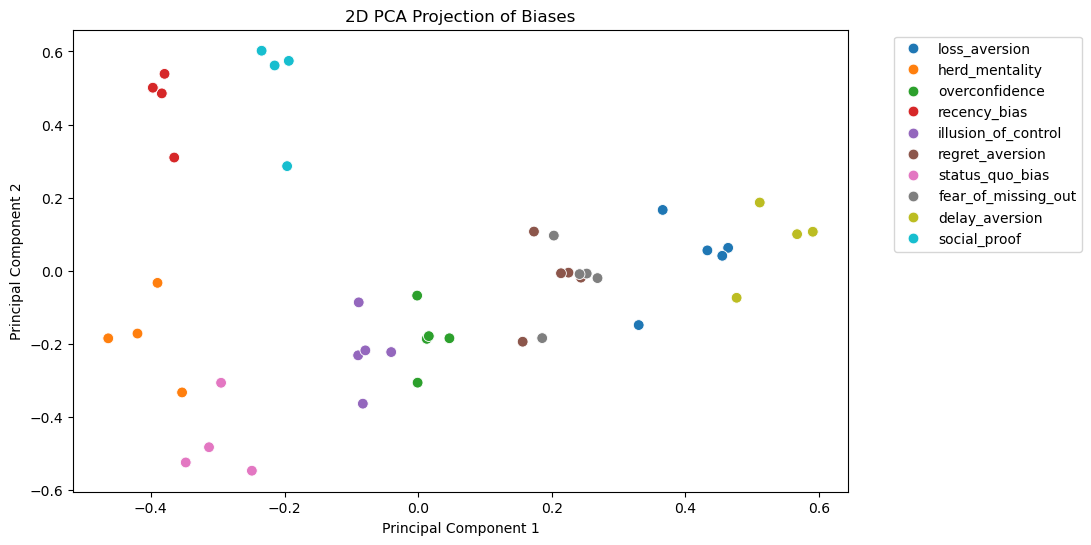

In [26]:
from sklearn.decomposition import PCA

X_dense = X.toarray()  # convert sparse matrix to dense
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["bias"] = y.values

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="bias", palette="tab10", s=60)
plt.title("2D PCA Projection of Biases")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
